In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import matplotlib

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
condition_key = 'Patient'
cell_type_key = 'Celltype'

vae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [5]:
adata_10x = sc.read_h5ad("/nfs/team283/aa16/data/Zika/zikaGlioblastomas_10X_SeuratObject.h5ad")
adata_SS = sc.read_h5ad("/nfs/team283/aa16/data/Zika/zikaGlioblastomas_SS_SeuratObject.h5ad")

In [6]:
adata_10x = adata_10x.raw.to_adata()
adata_SS = adata_SS.raw.to_adata()

In [7]:
adata_10x = remove_sparsity(adata_10x)
adata_SS = remove_sparsity(adata_SS)

In [8]:
adata_10x.obs['Celltype'] = adata_10x.obs['Celltype2']
adata_SS.obs['Celltype'] = adata_SS.obs['Celltype3']

In [9]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_10x, min_genes=1)
sc.pp.filter_genes(adata_10x, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_10x.var['n_cells'] = (adata_10x.X > 0).sum(0)
adata_10x.var['nonz_mean'] = adata_10x.X.sum(0) / adata_10x.var['n_cells']

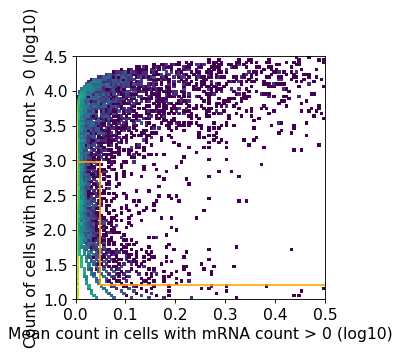

In [10]:
plt.hist2d(np.log10(adata_10x.var['nonz_mean']),
           np.log10(adata_10x.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells
cell_count_cutoff = np.log10(adata_10x.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_10x.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

# Show number of remaining cells:
adata_10x[:,(np.array(np.log10(adata_10x.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_10x.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_10x.var['n_cells']) > cell_count_cutoff)].shape

# Actually filter cells:
adata_10x = adata_10x[:,(np.array(np.log10(adata_10x.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_10x.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_10x.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_10x.var.index.isna())]

In [11]:
subset = np.intersect1d(adata_SS.var_names, adata_10x.var_names, return_indices = True)
adata_SS = adata_SS[:,subset[1]]
adata_10x = adata_10x[:,subset[2]]

In [12]:
adata_10x

View of AnnData object with n_obs × n_vars = 31748 × 10272
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'SampleName', 'Technology', 'ZikaExposure', 'Patient', 'percent.mt', 'MESlike_score', 'AClike_score', 'OPClike_score', 'NPClike_score', 'RNA_snn_res.0.5', 'seurat_clusters', 'Celltype', 'Celltype2', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells', 'nonz_mean'

In [13]:
adata_SS

View of AnnData object with n_obs × n_vars = 1726 × 10272
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'SampleName', 'Technology', 'ZikaExposure', 'Patient', 'percent.mt', 'predicted.id', 'prediction.score.Excitatory.Neuron', 'prediction.score.Inhibitory.Neuron', 'prediction.score.OPClike', 'prediction.score.Astrocyte', 'prediction.score.Microglia', 'prediction.score.Oligodendrocyte', 'prediction.score.Endothelial.Cells', 'prediction.score.AClike', 'prediction.score.MESlike', 'prediction.score.NPClike', 'prediction.score.max', 'Celltype', 'MESlike_score', 'AClike_score', 'OPClike_score', 'NPClike_score', 'RNA_snn_res.0.5', 'seurat_clusters', 'Celltype2', 'Celltype3'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [14]:
adata_10x = adata_10x.copy()

In [15]:
sca.dataset.setup_anndata(adata_10x, batch_key=condition_key)

INFO     Using batches from adata.obs["Patient"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 31748 cells, 10272 vars, 4        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [16]:
vae = sca.models.SCVI(
    adata_10x,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [17]:
vae.train(n_epochs=vae_epochs, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  36%|███▌      | 178/500 [08:43<16:03,  2.99s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  36%|███▌      | 178/500 [08:47<15:53,  2.96s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  318 s. / 500 epochs                                                 


In [18]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = adata_10x.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = adata_10x.obs[condition_key].tolist()
reference_latent.obs['patient'] = np.array(adata_10x.obs['Patient'])

... storing 'cell_type' as categorical
... storing 'batch' as categorical
... storing 'patient' as categorical


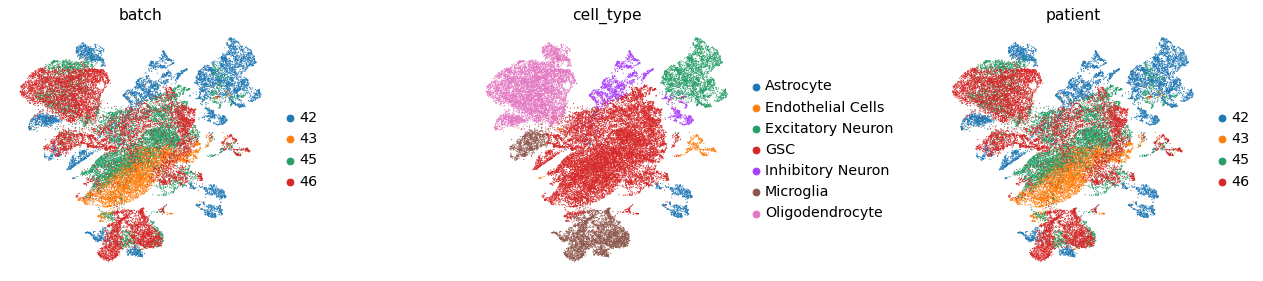

In [19]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type', 'patient'],
           frameon=False,
           wspace=0.6,
           )

In [20]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

In [21]:
model = sca.models.SCVI.load_query_data(
    adata_SS,
    ref_path,
    freeze_dropout = True,
)

Trying to set attribute `.uns` of view, copying.


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1726 cells, 10272 vars, 8 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [22]:
model.train(n_epochs=surgery_epochs, frequency=1, early_stopping_kwargs=early_stopping_kwargs, weight_decay=0)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  67%|██████▋   | 333/500 [00:51<00:27,  6.07it/s]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  67%|██████▋   | 333/500 [00:51<00:26,  6.42it/s]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  29 s. / 500 epochs                                                  


In [23]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = adata_SS.obs[cell_type_key].tolist()
query_latent.obs['batch'] = adata_SS.obs[condition_key].tolist()

<Figure size 320x320 with 0 Axes>

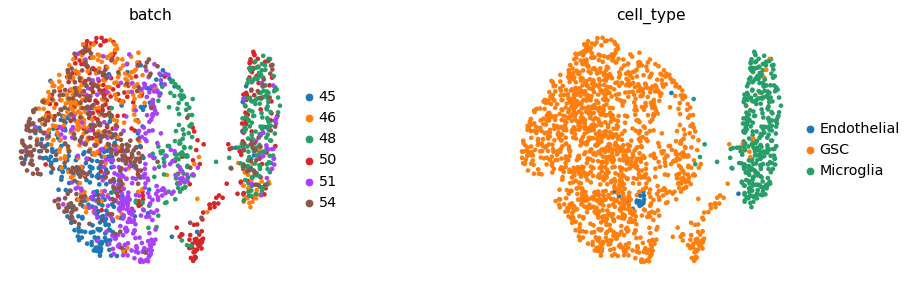

In [25]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=['batch', 'cell_type'],
    frameon=False,
    wspace=0.6,
)

In [28]:
adata_full = adata_10x.concatenate(adata_SS)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()
full_latent.obs['technology'] = adata_full.obs['Technology'].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 33474 cells, 10272 vars, 8        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [29]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)

... storing 'cell_type' as categorical
... storing 'batch' as categorical
... storing 'technology' as categorical


<Figure size 320x320 with 0 Axes>

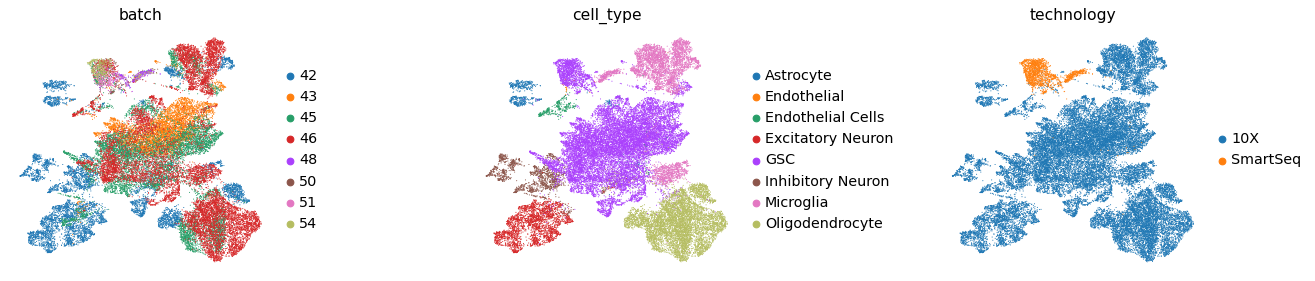

In [30]:
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type", "technology"],
    frameon=False,
    wspace=0.6,
)